In [51]:
import torch
import torchvision
import torch.nn as nn
import matplotlib.pyplot as plt
import torch.utils.tensorboard as tensorboard
import tqdm

In [52]:
# torch.set_default_tensor_type('torch.cuda.FloatTensor')

### 1. MNIST Data

In [124]:
data_transform = torchvision.transforms.Compose([
    torchvision.transforms.ToTensor(),
])

In [125]:
BATCH_SIZE = 64

In [126]:
train = torchvision.datasets.mnist.MNIST(
    root="./data", 
    train=True, 
    transform=data_transform, 
    download=True
)
val = torchvision.datasets.mnist.MNIST(
    root="./data", 
    train=False, 
    transform=data_transform, 
    download=True
)

In [127]:
train_loader = torch.utils.data.DataLoader(dataset=train, batch_size=BATCH_SIZE, shuffle=True)
val_loader = torch.utils.data.DataLoader(dataset=val, batch_size=BATCH_SIZE, shuffle=False)

#### Sample Visualization

torch.Size([64, 1, 28, 28]) torch.Size([64])


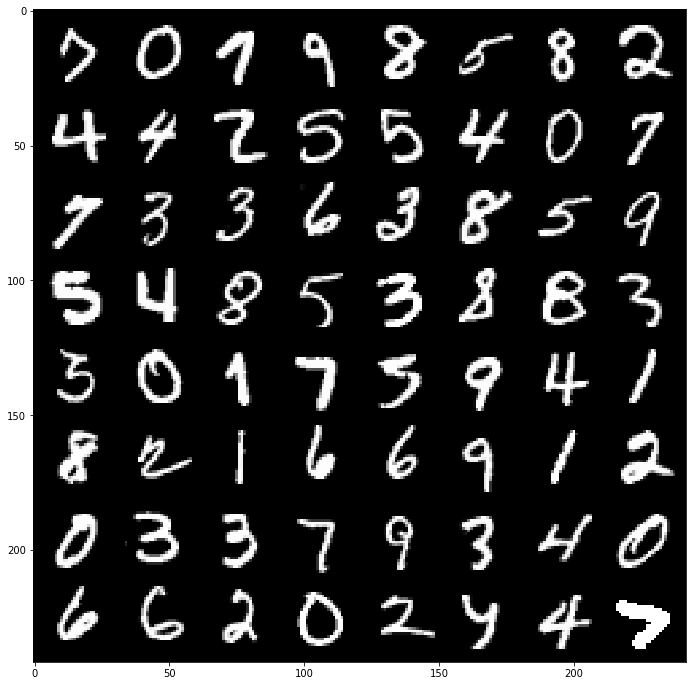

In [130]:
x, y = next(iter(train_loader))
print(x.size(), y.size()) 
grid = torchvision.utils.make_grid(x, nrow=8)
plt.figure(figsize=(12, 12))
plt.imshow(grid.permute(1, 2, 0), cmap="gray")
plt.show()

### 2. Model (Generative Adversarial Networks)

In [157]:
# Generator Network
class Generator(nn.Module):
    
    def __init__(self, noise_dim = 100, hidden_dims = [128, 256, 512, 784]):
        super(Generator, self).__init__()
        
        if hidden_dims is None:
            hidden_dims = [128, 256, 512, 784]
        
        generator_modules = []
        in_features = noise_dim
        for h_dim in hidden_dims:
            generator_modules.append(self.nn_layer(in_features=in_features, out_features=h_dim))
            in_features = h_dim
        
        self.generator = nn.Sequential(*generator_modules)
        
    # GAN paper suggest, its works better with Tanh activation
    def nn_layer(self, in_features, out_features):
        layer = nn.Sequential(
            nn.Linear(in_features=in_features, out_features=out_features),
            nn.Tanh()
        )
        return layer
    
    def forward(self, noise):
        # noise.size() -> [batch_size, featueres(noise_dim)]
        out = self.generator(noise)
        return out

    
class GeneratorNet(torch.nn.Module):
    """
    A three hidden-layer generative neural network
    """
    def __init__(self):
        super(GeneratorNet, self).__init__()
        n_features = 100
        n_out = 784
        
        self.hidden0 = nn.Sequential(
            nn.Linear(n_features, 256),
            nn.LeakyReLU(0.2)
        )
        self.hidden1 = nn.Sequential(            
            nn.Linear(256, 512),
            nn.LeakyReLU(0.2)
        )
        self.hidden2 = nn.Sequential(
            nn.Linear(512, 1024),
            nn.LeakyReLU(0.2)
        )
        
        self.out = nn.Sequential(
            nn.Linear(1024, n_out),
            nn.Tanh()
        )

    def forward(self, x):
        x = self.hidden0(x)
        x = self.hidden1(x)
        x = self.hidden2(x)
        x = self.out(x)
        return x



In [158]:
# Discriminator Network
class Discriminator(nn.Module):
    
    def __init__(self, in_features=784, hidden_dims = [512, 256, 128, 64, 32, 1], out_features = 1):
        
        super(Discriminator, self).__init__()
        
        if hidden_dims is None:
            hidden_dims = [512, 256, 128, 64, 32, 1]
        
        discriminator_modules = []
        for h_dim in hidden_dims:
            discriminator_modules.append(self.nn_layer(in_features=in_features, out_features=h_dim))
            in_features = h_dim
        
        self.discriminator = nn.Sequential(*discriminator_modules)
    
    def nn_layer(self, in_features, out_features):
        layer = nn.Sequential(
            nn.Linear(in_features=in_features, out_features=out_features),
            nn.Sigmoid()
        )
        return layer

    def forward(self, x):
        # x.size -> [batch, 28*28]
        out = self.discriminator(x)
        return out

class DiscriminatorNet(torch.nn.Module):
    """
    A three hidden-layer discriminative neural network
    """
    def __init__(self):
        super(DiscriminatorNet, self).__init__()
        n_features = 784
        n_out = 1
        
        self.hidden0 = nn.Sequential( 
            nn.Linear(n_features, 1024),
            nn.LeakyReLU(0.2),
            nn.Dropout(0.3)
        )
        self.hidden1 = nn.Sequential(
            nn.Linear(1024, 512),
            nn.LeakyReLU(0.2),
            nn.Dropout(0.3)
        )
        self.hidden2 = nn.Sequential(
            nn.Linear(512, 256),
            nn.LeakyReLU(0.2),
            nn.Dropout(0.3)
        )
        self.out = nn.Sequential(
            torch.nn.Linear(256, n_out),
            torch.nn.Sigmoid()
        )

    def forward(self, x):
        x = self.hidden0(x)
        x = self.hidden1(x)
        x = self.hidden2(x)
        x = self.out(x)
        return x


### Training the GAN(It's pretty challenging)

In [156]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

In [133]:
# device

In [159]:
## generator and discriminator model
gen = GeneratorNet().to(device)
disc = DiscriminatorNet().to(device)

In [160]:
NOISE_DIM = 100
lr = 1e-2
EPOCHS = 10
writer = tensorboard.SummaryWriter()

In [161]:
## loss and optimizer, two different optimizer will be used
criterion = nn.MSELoss().to(device)
optimizer_g = torch.optim.Adam(params=gen.parameters(), lr=lr)
optimizer_d = torch.optim.Adam(params=disc.parameters(), lr=lr)

In [162]:
steps = 0
epoch_progress = tqdm.tqdm(total=EPOCHS, desc="EPOCH", position=0)

for epoch in range(EPOCHS):
    
    epoch_loss_d = []
    epoch_loss_g = []
    
    step_progress = tqdm.tqdm(total=len(train_loader), desc="STEP", position=0)
    
    for i, (images, _) in enumerate(train_loader):
        
        # images.size() = [batch, channel, h, w]  -> [batch, channel*h*w]
        # although c, h, w will be constant, so it can be declared outside the training loop
        
        
        # Training Discriminator
        images = images.to(device)
        
        #disc.train =  True
        #gen.train = False
        
        batch, channel, h, w = images.size(0), images.size(1), images.size(2), images.size(3)
        
        gt_real = torch.ones(batch, device=device)
        
        
        # fake data generation
        noise = torch.randn((batch, NOISE_DIM), device=device)  # noise
        
        
        fake_data = gen(noise) # fake data 
        gt_fake = torch.zeros(batch, device=device) # set label as 0 for fake data dicriminator training
        
        
        # contcat the real and fake samples along with labels and shuffle it
        batch_data, labels = torch.cat((images.view(batch, channel*h*w), fake_data)), torch.cat((gt_real, gt_fake))
        
        
        # calculate the loss and backpropagate it
        outputs = disc(batch_data)
        
        optimizer_d.zero_grad()
        loss_d = criterion(outputs, labels)
        loss_d.backward()
        optimizer_d.step()
        
        
        # Training Generator        
        #disc.train =  False
        #gen.train = True
        
        optimizer_g.zero_grad()
        loss_g = criterion(disc(gen(noise)), gt_real)
        loss_g.backward()
        optimizer_g.step()
        
        
        if steps%500==0:
            print(f'Epoch {epoch} | Step {steps} | loss_d {loss_d.item()} | loss_g {loss_g}')
        
        # writer the logs into tensorboard  
        writer.add_scalar("steps loss_d", loss_d, steps)
        writer.add_scalar("steps loss_g", loss_g, steps)
        # append the steps loss into epoch loss
        epoch_loss_d.append(loss_d)
        epoch_loss_g.append(loss_g)
        # increase the steps and update the progress
        steps += 1
        step_progress.update(1)
       
    
    # Calculate the mean generator and discriminator loss
    # Upd
    avg_loss_d = sum(epoch_loss_d)/len(epoch_loss_d)
    avg_loss_g = sum(epoch_loss_g)/len(epoch_loss_g)
    print(f'EPOCH {epoch} | Loss_D {avg_loss_d} | Loss_G {avg_loss_g}')
    writer.add_scalar("Epoch Loss_D", avg_loss_d, epoch)
    writer.add_scalar("Epoch Loss_G", avg_loss_g, epoch)
    epoch_progress.update(1)

STEP:   0%|          | 0/938 [00:00<?, ?it/s]/home/macab/miniconda3/lib/python3.7/site-packages/torch/nn/modules/loss.py:432: UserWarning: Using a target size (torch.Size([128])) that is different to the input size (torch.Size([128, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
/home/macab/miniconda3/lib/python3.7/site-packages/torch/nn/modules/loss.py:432: UserWarning: Using a target size (torch.Size([64])) that is different to the input size (torch.Size([64, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
STEP:   1%|▏         | 12/938 [00:00<07:43,  2.00it/s]

Epoch 0 | Step 0 | loss_d 0.25002527236938477 | loss_g 0.9032150506973267


STEP:  55%|█████▍    | 512/938 [00:05<00:03, 114.70it/s]

Epoch 0 | Step 500 | loss_d 0.5 | loss_g 0.0


STEP:  99%|█████████▉| 932/938 [00:08<00:00, 113.04it/s]/home/macab/miniconda3/lib/python3.7/site-packages/torch/nn/modules/loss.py:432: UserWarning: Using a target size (torch.Size([32])) that is different to the input size (torch.Size([32, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
STEP:   1%|          | 11/938 [00:00<00:08, 106.95it/s]

EPOCH 0 | Loss_D 0.49969831109046936 | Loss_G 0.0021132761612534523


STEP:   9%|▊         | 82/938 [00:00<00:07, 113.20it/s]

Epoch 1 | Step 1000 | loss_d 0.5 | loss_g 0.0


STEP:  61%|██████    | 574/938 [00:04<00:03, 116.01it/s]

Epoch 1 | Step 1500 | loss_d 0.5 | loss_g 0.0


STEP:   1%|          | 11/938 [00:00<00:08, 105.97it/s]]

EPOCH 1 | Loss_D 0.5 | Loss_G 0.0


STEP:  15%|█▌        | 142/938 [00:01<00:07, 112.09it/s]

Epoch 2 | Step 2000 | loss_d 0.5 | loss_g 0.0


STEP:  68%|██████▊   | 639/938 [00:05<00:02, 114.43it/s]

Epoch 2 | Step 2500 | loss_d 0.5 | loss_g 0.0


STEP:   1%|          | 11/938 [00:00<00:08, 109.42it/s]]

EPOCH 2 | Loss_D 0.5 | Loss_G 0.0


STEP:  22%|██▏       | 203/938 [00:01<00:06, 117.61it/s]

Epoch 3 | Step 3000 | loss_d 0.5 | loss_g 0.0


STEP:  75%|███████▍  | 699/938 [00:05<00:02, 118.60it/s]

Epoch 3 | Step 3500 | loss_d 0.5 | loss_g 0.0


STEP:   1%|          | 11/938 [00:00<00:09, 101.66it/s]

EPOCH 3 | Loss_D 0.5 | Loss_G 0.0


STEP:  28%|██▊       | 264/938 [00:02<00:06, 100.39it/s]

Epoch 4 | Step 4000 | loss_d 0.5 | loss_g 0.0


STEP:  61%|██████▏   | 575/938 [00:05<00:03, 110.19it/s]

KeyboardInterrupt: 

#### Test the model

In [163]:
fake_data = torch.randn((1, 100), device=device)

In [164]:
x = gen(fake_data)

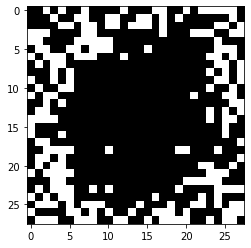

STEP:  62%|██████▏   | 580/938 [00:20<00:03, 110.19it/s]

In [165]:
plt.imshow(x.cpu().detach().view(28, 28), cmap="gray")

In [153]:
fake_data = torch.randn((1, 100), device=device)
gen(fake_data)

tensor([[3.7818e-04, 9.9985e-01, 3.8761e-04, 9.9993e-01, 5.3393e-04, 9.9996e-01,
         1.0000e+00, 4.9289e-04, 9.9996e-01, 1.6083e-03, 1.0072e-04, 3.0084e-04,
         1.8000e-04, 1.2511e-04, 2.5748e-04, 3.5750e-04, 9.9979e-01, 9.9985e-01,
         9.9958e-01, 3.0150e-04, 1.0000e+00, 9.9925e-01, 9.9998e-01, 1.0000e+00,
         9.9999e-01, 9.9963e-01, 9.9996e-01, 9.9974e-01, 9.9999e-01, 9.9998e-01,
         1.4403e-04, 3.4208e-04, 5.8223e-04, 9.9993e-01, 9.9999e-01, 9.9921e-01,
         1.7849e-04, 8.9707e-05, 1.2090e-04, 9.9959e-01, 5.5062e-05, 9.9996e-01,
         4.4387e-04, 9.9998e-01, 9.9993e-01, 4.0383e-04, 1.3217e-03, 1.9865e-04,
         2.9003e-04, 1.0000e+00, 2.9228e-04, 7.0674e-05, 2.1848e-04, 9.9980e-01,
         3.2514e-04, 8.3259e-04, 7.5604e-04, 9.9951e-01, 6.3623e-04, 1.4563e-05,
         9.9982e-01, 9.9960e-01, 1.0000e+00, 6.0390e-05, 2.5105e-04, 9.9997e-01,
         9.9793e-01, 1.0000e+00, 3.3427e-05, 7.9636e-01, 1.0887e-03, 2.4763e-04,
         2.3911e-04, 9.9962e

In [154]:
x, y = next(iter(train_loader))

In [104]:
x[0]

tensor([[[0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
          0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
          0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
          0.0000, 0.0000, 0.0000, 0.0000],
         [0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
          0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
          0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
          0.0000, 0.0000, 0.0000, 0.0000],
         [0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
          0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
          0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
          0.0000, 0.0000, 0.0000, 0.0000],
         [0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
          0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
          0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,